# Baseline ML Model: Climate Anomaly Events

This notebook trains baseline machine learning models to predict **next-month anomaly events** using the `gold_ml_features` table produced by the dbt + DuckDB pipeline.

Target variable: `is_event_next_month` (1 = strong hot/cold anomaly next month, 0 = otherwise).

In [1]:
# Imports
import duckdb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Connect to DuckDB and load ML dataset
DB_PATH = "../data/warehouse/climate.duckdb"

con = duckdb.connect(DB_PATH, read_only=True)

df = con.execute("""
    SELECT *
    FROM gold_ml_features
""").df()

df.head()

,city_id,city_name,year,month,sin_month,cos_month,anomaly_tmean_c,roll_mean_3,roll_mean_6,roll_std_3,roll_std_6,delta_1m,delta_3m,max_lagged_corr,lead_lag_months,is_event_next_month
0,4,Porto,1980,1,0.500000,8.660254e-01,0.377312,0.377312,0.377312,NaN,NaN,NaN,NaN,0.878895,0,0
1,4,Porto,1980,2,0.866025,5.000000e-01,0.351872,0.364592,0.364592,0.017989,0.017989,-0.025440,NaN,0.878895,0,0
2,4,Porto,1980,3,1.000000,6.123234e-17,-0.958925,-0.076580,-0.076580,0.764239,0.764239,-1.310797,NaN,0.878895,0,0
3,4,Porto,1980,4,0.866025,-5.000000e-01,0.565778,-0.013758,0.084009,0.825496,0.701805,1.524703,0.188466,0.878895,0,0
4,4,Porto,1980,5,0.500000,-8.660254e-01,-1.200538,-0.531228,-0.172900,0.957685,0.836307,-1.766315,-1.552410,0.878895,0,0


## Quick sanity checks on the ML dataset

In [3]:
df.shape

(2160, 16)

In [4]:
df.isna().sum().sort_values(ascending=False).head(20)

delta_3m               12
roll_std_3              4
roll_std_6              4
delta_1m                4
city_id                 0
city_name               0
year                    0
month                   0
sin_month               0
cos_month               0
anomaly_tmean_c         0
roll_mean_3             0
roll_mean_6             0
max_lagged_corr         0
lead_lag_months         0
is_event_next_month     0
dtype: int64

In [5]:
df['is_event_next_month'].value_counts(normalize=True)

is_event_next_month
0    0.949537
1    0.050463
Name: proportion, dtype: float64

## Define features and target

In [9]:
target = "is_event_next_month"

features = [
    "anomaly_tmean_c",
    "roll_mean_3",
    "roll_mean_6",
    "roll_std_3",
    "roll_std_6",
    "delta_1m",
    "delta_3m",
    "max_lagged_corr",
    "lead_lag_months",
    "sin_month",
    "cos_month",
]

# Drop rows where any feature is NaN
df = df.dropna(subset=features).reset_index(drop=True)

X = df[features].copy()
y = df[target].copy()

X.describe()

,anomaly_tmean_c,roll_mean_3,roll_mean_6,roll_std_3,roll_std_6,delta_1m,delta_3m,max_lagged_corr,lead_lag_months,sin_month,cos_month
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.0,2.148000e+03,2.148000e+03
mean,0.082299,0.079517,0.078552,0.903910,1.037991,0.003541,0.006090,0.781104,0.0,-4.406006e-03,-2.543809e-03
std,1.214988,0.868799,0.667037,0.511787,0.392493,1.414607,1.683454,0.097814,0.0,7.065988e-01,7.079251e-01
min,-4.175000,-2.772246,-2.236392,0.024227,0.210557,-6.085679,-5.796294,0.683313,0.0,-1.000000e+00,-1.000000e+00
25%,-0.758513,-0.530149,-0.379884,0.514868,0.741992,-0.896555,-1.081273,0.683313,0.0,-8.660254e-01,-8.660254e-01
50%,0.017754,0.045079,0.049117,0.823940,1.005831,-0.042106,-0.030984,0.781104,0.0,-2.449294e-16,-1.836970e-16
75%,0.870901,0.646538,0.521846,1.210671,1.270754,0.877218,1.056004,0.878895,0.0,5.000000e-01,5.000000e-01
max,4.890860,3.595211,2.745481,3.181349,2.645246,4.855768,5.966452,0.878895,0.0,1.000000e+00,1.000000e+00


## Time-aware train/test split

We sort by `(city_id, year, month)` and use the first ~75% for training, the remaining ~25% for testing.

In [10]:
df_sorted = df.sort_values(["city_id", "year", "month"]).reset_index(drop=True)

X_sorted = df_sorted[features]
y_sorted = df_sorted[target]

cutoff = int(len(df_sorted) * 0.75)

X_train = X_sorted.iloc[:cutoff]
X_test  = X_sorted.iloc[cutoff:]
y_train = y_sorted.iloc[:cutoff]
y_test  = y_sorted.iloc[cutoff:]

X_train.shape, X_test.shape

((1611, 11), (537, 11))

## Baseline model 1: Logistic Regression

In [11]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression classification report:")
print(classification_report(y_test, y_pred_lr))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

try:
    auc_lr = roc_auc_score(y_test, y_prob_lr)
    print(f"ROC-AUC: {auc_lr:.3f}")
except ValueError:
    print("ROC-AUC could not be computed (possibly only one class present in y_test).")

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.96      0.46      0.62       512
           1       0.05      0.56      0.09        25

    accuracy                           0.46       537
   macro avg       0.50      0.51      0.35       537
weighted avg       0.91      0.46      0.60       537

Confusion matrix:
[[235 277]
 [ 11  14]]
ROC-AUC: 0.560


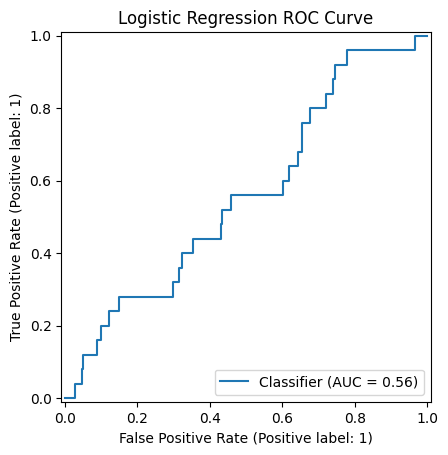

In [12]:
# ROC curve (if both classes present)
if len(np.unique(y_test)) == 2:
    RocCurveDisplay.from_predictions(y_test, y_prob_lr)
    plt.title("Logistic Regression ROC Curve")
    plt.show()

## Baseline model 2: Random Forest

In [13]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight="balanced",
    random_state=42,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

try:
    auc_rf = roc_auc_score(y_test, y_prob_rf)
    print(f"ROC-AUC: {auc_rf:.3f}")
except ValueError:
    print("ROC-AUC could not be computed (possibly only one class present in y_test).")

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       512
           1       0.00      0.00      0.00        25

    accuracy                           0.95       537
   macro avg       0.48      0.50      0.49       537
weighted avg       0.91      0.95      0.93       537

Confusion matrix:
[[512   0]
 [ 25   0]]
ROC-AUC: 0.630


/Users/chranama/portfolio/california-portugal-climate/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/chranama/portfolio/california-portugal-climate/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/chranama/portfolio/california-portugal-climate/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

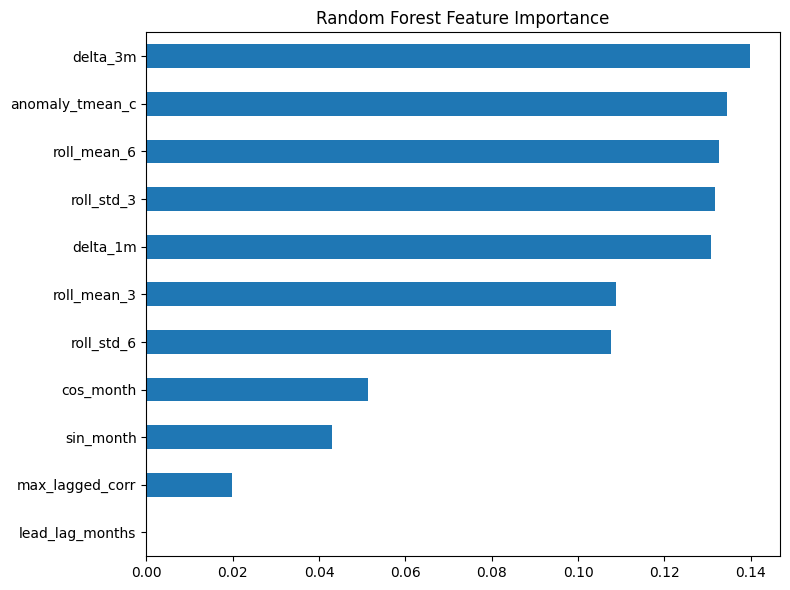

In [14]:
# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8, 6))
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [16]:
print("Class distribution (y_test):")
print(y_test.value_counts())

print("\nPredicted distribution (RF):")
print(pd.Series(rf.predict(X_test)).value_counts())

Class distribution (y_test):
is_event_next_month
0    512
1     25
Name: count, dtype: int64

Predicted distribution (RF):
0    537
Name: count, dtype: int64


## Next steps

Some concrete extensions you can implement later:

- Try gradient boosting (XGBoost / LightGBM / HistGradientBoostingClassifier)
- Do per-city models vs global model
- Perform hyperparameter tuning (GridSearchCV / RandomizedSearchCV)
- Add more features (e.g., precipitation anomalies, lagged event flags)
- Use model outputs as a signal in your future dashboard.